In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data = pd.read_csv('titanic.csv')
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
data = data[['Survived', 'Age', 'Embarked']]
data.head(2)

,Survived,Age,Embarked
0,0,22.0,S
1,1,38.0,C


### Categorical Column

In [5]:
data.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [6]:
data.Embarked.fillna('Nulls', inplace  = True)

In [7]:
def woe_discrete(df, discrete_var_name, good_bad_var_name):
    df = pd.concat([df[discrete_var_name], df[good_bad_var_name]], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                   df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].sum()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs']/df['n_obs'].sum()
    df['n_good'] = df['prop_good']*df['n_obs']
    df['n_bad'] = (1-df['prop_good'])*df['n_obs']
    df['prop_n_good'] = df['n_good']/df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad']/df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [8]:
df_emb = woe_discrete(data,'Embarked', 'Survived')
df_emb

,Embarked,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,S,644,217,0.722783,139748,-139104,0.886242,0.887171,-0.001048,NaN,NaN,0.000024
1,C,168,93,0.188552,15624,-15456,0.099083,0.098575,0.005144,124.0,0.006192,0.000024
2,Q,77,30,0.086420,2310,-2233,0.014649,0.014242,0.028235,63.0,0.023091,0.000024
3,Nulls,2,2,0.002245,4,-2,0.000025,0.000013,0.687481,28.0,0.659246,0.000024


In [9]:
def plot_by_woe(df_WoE, rotation_of_x_axis_lables = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize = (18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_lables)

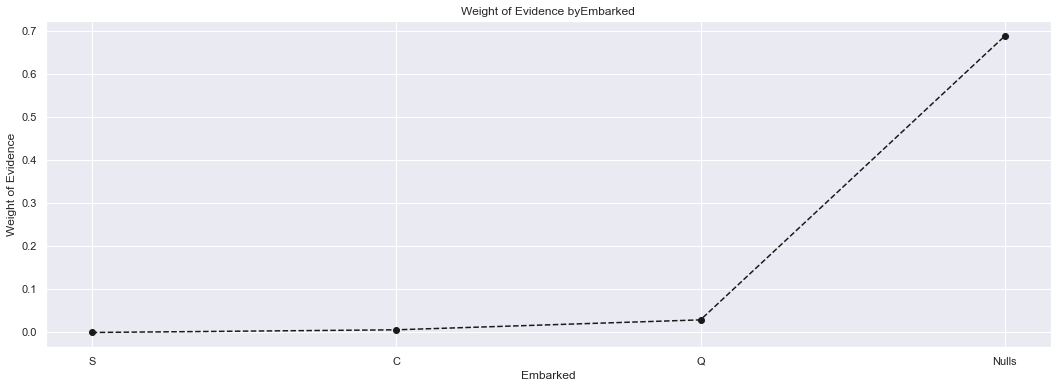

In [10]:
plot_by_woe(df_emb)

We would replace 'Nulls' with 'Q' as that category having closest WoE value.

In [11]:
data.Embarked = data.Embarked.map({'S':'S',
                                   'C':'C',
                                   'Q':'Q',
                                   'Nulls' : 'Q'})
data.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [12]:
df_emb = woe_discrete(data,'Embarked', 'Survived')
df_emb

,Embarked,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,S,644,217,0.722783,139748,-139104,0.885041,0.885962,-0.001040,NaN,NaN,0.000014
1,C,168,93,0.188552,15624,-15456,0.098949,0.098440,0.005152,124.0,0.006192,0.000014
2,Q,79,32,0.088664,2528,-2449,0.016010,0.015598,0.026090,61.0,0.020938,0.000014


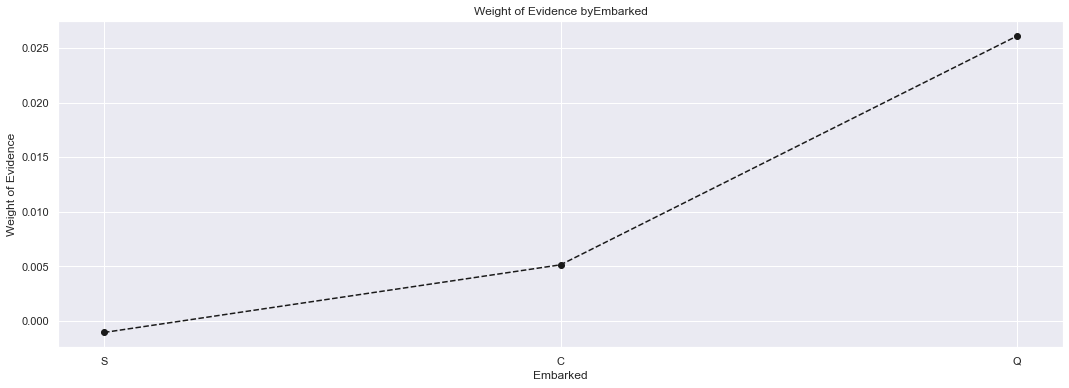

In [13]:
plot_by_woe(df_emb)

We can not merge any more categories as they have significant number of observations with different WoE values. Hence, we would finalize these three categories for model development. Next step should be convert them to dummies and use them.

In [14]:
dummies = pd.get_dummies(data.Embarked)
dummies.head()

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


### Numeric Column

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Age       714 non-null    float64
 2   Embarked  891 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 21.0+ KB


In [16]:
data.Age.fillna(data.Age.median(), inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Age       891 non-null    float64
 2   Embarked  891 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 21.0+ KB


In [17]:
def woe_ordered_cont(df, discrete_var_name, good_bad_var_name):
    df = pd.concat([df[discrete_var_name], df[good_bad_var_name]], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                   df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].sum()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs']/df['n_obs'].sum()
    df['n_good'] = df['prop_good']*df['n_obs']
    df['n_bad'] = (1-df['prop_good'])*df['n_obs']
    df['prop_n_good'] = df['n_good']/df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad']/df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
#     df = df.sort_values(['WoE'])
#     df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [18]:
data.Age.nunique()

88

In [19]:
data['Age_factor'] = pd.cut(data.Age, 10)
data['Age_factor']

0      (16.336, 24.294]
1       (32.252, 40.21]
2      (24.294, 32.252]
3       (32.252, 40.21]
4       (32.252, 40.21]
             ...       
886    (24.294, 32.252]
887    (16.336, 24.294]
888    (24.294, 32.252]
889    (24.294, 32.252]
890    (24.294, 32.252]
Name: Age_factor, Length: 891, dtype: category
Categories (10, interval[float64, right]): [(0.34, 8.378] < (8.378, 16.336] < (16.336, 24.294] < (24.294, 32.252] ... (48.168, 56.126] < (56.126, 64.084] < (64.084, 72.042] < (72.042, 80.0]]

In [20]:
df_temp = woe_ordered_cont(data, 'Age_factor', 'Survived')
df_temp

C:\Users\Kishan\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Kishan\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Age_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.34, 8.378]",54,36,0.060606,1944,-1890,0.030648,0.030221,0.014024,NaN,NaN,-inf
1,"(8.378, 16.336]",46,19,0.051627,874,-828,0.013779,0.013240,0.039921,17.0,0.025896,-inf
2,"(16.336, 24.294]",177,63,0.198653,11151,-10974,0.175800,0.175475,0.001854,44.0,0.038067,-inf
3,"(24.294, 32.252]",346,117,0.388328,40482,-40136,0.638215,0.641776,-0.005563,54.0,0.007417,-inf
4,"(32.252, 40.21]",118,52,0.132435,6136,-6018,0.096737,0.096228,0.005272,65.0,0.010834,-inf
5,"(40.21, 48.168]",70,24,0.078563,1680,-1610,0.026486,0.025744,0.028413,28.0,0.023142,-inf
6,"(48.168, 56.126]",45,21,0.050505,945,-900,0.014898,0.014391,0.034644,3.0,0.006231,-inf
7,"(56.126, 64.084]",24,9,0.026936,216,-192,0.003405,0.003070,0.103636,12.0,0.068993,-inf
8,"(64.084, 72.042]",9,0,0.010101,0,9,0.000000,-0.000144,-inf,9.0,inf,-inf
9,"(72.042, 80.0]",2,1,0.002245,2,0,0.000032,-0.000000,NaN,1.0,NaN,-inf


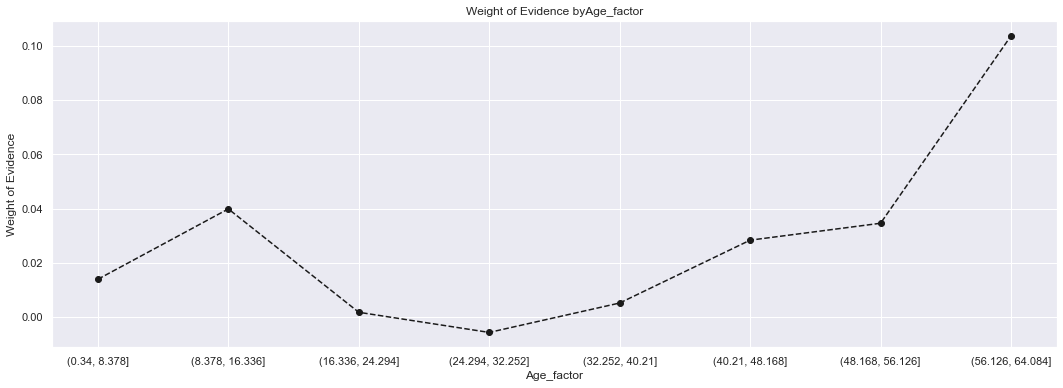

In [21]:
plot_by_woe(df_temp)

Required categories:
- 'Age:<9'
- 'Age:9-17'
- 'Age:17-41'
- 'Age:41-57'
- 'Age:>=57'

In [22]:
data['Age:<9'] = np.where(data['Age'].isin(range(9)), 1, 0)
data['Age:9-17'] = np.where(data['Age'].isin(range(9, 17)), 1, 0)
data['Age:17-41'] = np.where(data['Age'].isin(range(17, 41)), 1, 0)
data['Age:41-57'] = np.where(data['Age'].isin(range(41, 57)), 1, 0)
data['Age:>57'] = np.where(data['Age'].isin(range(57, int(data['Age'].max()))), 1, 0)
                           
data.head()

,Survived,Age,Embarked,Age_factor,Age:<9,Age:9-17,Age:17-41,Age:41-57,Age:>57
0,0,22.0,S,"(16.336, 24.294]",0,0,1,0,0
1,1,38.0,C,"(32.252, 40.21]",0,0,1,0,0
2,1,26.0,S,"(24.294, 32.252]",0,0,1,0,0
3,1,35.0,S,"(32.252, 40.21]",0,0,1,0,0
4,0,35.0,S,"(32.252, 40.21]",0,0,1,0,0


----------------